<a href="https://colab.research.google.com/github/D34dP0oL/4216_Biomedical_DS_and_AI/blob/main/Sheet4/Assignment4_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [164]:
import numpy as np
import math
import pandas as pd

from scipy.stats import poisson, sem, poisson, ttest_ind, shapiro, mannwhitneyu
import scipy.stats as stats # for 'f_oneway'
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

from sklearn import linear_model 
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

import statsmodels.formula.api as sm # get ANOVA table as R like output
from statsmodels.formula.api import ols # Ordinary Least Squares (OLS) model

import matplotlib.pyplot as plt
from IPython.display import display, HTML
from scipy.cluster.hierarchy import dendrogram, linkage
from mpl_toolkits.mplot3d import Axes3D

## Biomedical Data Science & AI

## Assignment 4

#### Group members:  Fabrice Beaumont, Fatemeh Salehi, Genivika Mann, Helia Salimi, Jonah

---
### Exercise 1 - ANOVA *F*-test and Hierarchical Clustering
Load the leukemia dataset (`leukemia.csv`). It contains gene expression data of 1397 genes from 38
tumor mRNA samples. The expression data is organized in a matrix where rows
correspond to genes and columns to samples. The tumor class of the columns is given in the file `golub.cl`.

In [165]:
leukemia_db = pd.read_csv('https://raw.githubusercontent.com/D34dP0oL/4216_Biomedical_DS_and_AI/main/Sheet4/leukemia.csv', index_col='gene_name')
leukemia_db.head(4)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38
gene_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AFFX-HUMISGF3A/M97935_3_at,0.45695,-0.09654,0.90325,-0.07194,0.03232,0.09713,-0.11978,0.23381,0.23987,0.44201,-0.39560,-0.62533,0.45181,1.09519,1.09318,0.34300,0.20010,0.38992,0.00641,1.10932,0.21952,-0.72267,0.51690,0.28577,0.61937,0.20085,0.29278,0.26624,-0.43377,-0.10823,-0.29385,0.05067,1.69430,-0.12472,0.04609,0.24347,0.90774,0.46509
AFFX-HUMTFRR/M11507_5_at,-0.56223,0.05358,0.12612,-0.84016,-0.43710,-0.38536,-0.87284,0.07453,-0.36118,-1.21583,-0.40243,-0.19383,-0.82254,-0.97149,-0.91163,-1.12340,-0.22390,-0.13425,-0.77756,-0.73043,-1.06221,-0.13176,-0.02375,-0.62739,-0.15690,-0.77535,-0.84190,0.33921,0.51484,-0.13601,-0.16682,-0.20888,0.25911,-0.21631,0.19129,-0.57687,0.44808,1.19275
AFFX-M27830_M_at,2.40116,1.83222,1.62478,1.59089,0.75700,2.32267,1.64407,2.10957,1.64361,0.32217,1.94740,3.03783,0.57267,1.25632,1.76238,0.87822,0.29212,2.75831,0.94379,0.19046,1.26587,3.06374,3.29195,0.74052,2.98852,1.64597,2.17242,1.54761,1.03327,1.16119,2.25875,1.62017,0.91712,1.50523,2.21754,1.23143,1.87913,2.49036
AFFX-HUMGAPDH/M33197_3_st,0.10806,0.08245,0.48019,-0.29554,-1.25777,0.40172,0.06140,-0.33715,0.22733,-0.57804,0.07233,0.81717,-1.08971,-0.13572,-0.09442,-0.72484,-1.00308,0.18150,-0.40358,-0.64389,-1.02620,0.25894,-0.19135,-1.48332,0.76284,-0.66419,-0.18517,-0.04229,-1.08902,-0.48494,-0.25817,-0.44108,-0.20584,0.29198,-0.01033,-0.08370,-0.11911,0.48378


In [166]:
leukemia_db.shape

(1397, 38)

In [167]:
tumor_class_db = pd.read_csv('https://raw.githubusercontent.com/D34dP0oL/4216_Biomedical_DS_and_AI/main/Sheet4/golub.cl.csv', index_col='Unnamed: 0')
tumor_class_db.head(4)

,x
1,0
2,0
3,0
4,0


In [168]:
### Lets check, that exactly two types of Leukemia (0 and 1) are identified
tumor_class_db.values.T

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [169]:
tumor_class_db.shape

(38, 1)

#### 1.1. ANOVA *F*-test

##### 1.1.a. What are the assumptions of the ANOVA *F*-test?

To conduct an ANOVA *F*-test one assumes that:
- The variances in the studied groups of samples is the same (**homoscedasticity**)
- A linear model can sufficiently fit the group means (**no heteroscedastic noise**).
- The residuals are normally distributed.

Sidenote to the foreign words:
- A vector of random variables is **homoscedastic**, if all its random variables have the same finite variance.
- A vector of random variables is "heteroscedastic", if the variability of the random disturbance is different across elements of the vector

(Greek: *hetero* "different", *homo* "equal", *skedasis* "dispersion")

##### 1.1.b. For each gene in the dataset, perform the ANOVA *F*-test (assumptions are already met) to see whether the gene is significantly differentially expressed between the two types of Leukemia.

In [170]:
### For every gene we conduct an ANOVA F-test with the same null hypothesis:
### Null hypothesis: "The group means of type 0 of leukemia and type 1 of leukemia are equal."
print("The genes that are significantly differentially expressed between the two types of Leukemia are:")
### Store all signifiant genes in a dataframe
signif_genes = pd.DataFrame(columns=['gene_name', 'p-value', 'F-value'])

### From the 'tumor_class_db' get the indices of the two tpyes of leukemia
type_zero_indices = tumor_class_db.index[tumor_class_db['x'] == 0].tolist()
type_one_indices = tumor_class_db.index[tumor_class_db['x'] == 1].tolist()
### Since the 'tumor_class_db' counts the first row as '1' and not '0', we need to shift all indices by '-1'
type_zero_indices = [x - 1 for x in type_zero_indices] 
type_one_indices = [x - 1 for x in type_one_indices] 

### Iterate through all genes
for gene in leukemia_db.index:
    ### Differentiate all columns/ samples that belong to the two different types of leukemia
    gene_expressions_type_zero = leukemia_db.loc[gene].iloc[type_zero_indices].tolist()
    gene_expressions_type_one = leukemia_db.loc[gene].iloc[type_one_indices].tolist()

    ### Stats 'f_oneway' functions takes the two groups as input and returns ANOVA F- and p-value
    fvalue, pvalue = stats.f_oneway(gene_expressions_type_zero, gene_expressions_type_one)
    ### A p-value < 0.05 is significant. Print the name of the gene if that is the case
    if pvalue < 0.05:        
        signif_genes = signif_genes.append({'gene_name' : gene, 'p-value' : pvalue, 'F-value' : fvalue}, ignore_index=True)    

signif_genes

The genes that are significantly differentially expressed between the two types of Leukemia are:


,gene_name,p-value,F-value
0,AFFX-HUMTFRR/M11507_5_at,0.000072,20.086635
1,AB000449_at,0.000850,13.247115
2,AB000468_at,0.039889,4.545975
3,AC000064_cds1_at,0.022949,5.644936
4,AF008937_at,0.011464,7.099773
...,...,...,...
480,U40279_at,0.002999,10.133038
481,X17093_at,0.025641,5.420034
482,Z30643_at,0.044146,4.350522
483,U04241_at,0.044844,4.320449


In [171]:
nr_all_genes = len(leukemia_db)
nr_signif_genes = len(signif_genes)
signif_percentage = nr_signif_genes / nr_all_genes
print(f"Out of the {nr_all_genes} genes, {nr_signif_genes} are significantly differentially expressed between the two types of Leukemia.")
print(f"That is about {round(signif_percentage*100, 2)}%")

Out of the 1397 genes, 485 are significantly differentially expressed between the two types of Leukemia.
That is about 34.72%


##### 1.1.c. Due to our analysis, we now know which genes are significantly differentially expressed between groups. These will be the best features to use in order to get good cluster separation. Subset only the rows which represent the top 100 most significant genes.

In [172]:
### The genes are more significant, the lower their p-value is. 
### Thus return the 100 genes with the lowest p-value:
most_signif_100_genes = signif_genes.nsmallest(100, 'p-value')
most_signif_100_genes

,gene_name,p-value,F-value
155,M63138_at,2.366804e-08,50.530583
243,U50136_rna1_at,2.519519e-08,50.235874
478,M31523_at,2.713676e-08,49.887317
124,M16038_at,4.802350e-08,47.255323
173,M92287_at,6.046048e-08,46.217096
...,...,...,...
137,M28209_at,2.294286e-04,16.754857
169,M83221_at,2.310119e-04,16.735696
219,U30521_at,2.363345e-04,16.672289
422,HG627-HT5097_s_at,2.443697e-04,16.579380


#### 1.2. Plot 2 dendrograms using the 100 selected genes:

In [173]:
### See this awesome website for further information:
### https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

##### 1.2.a. One for a single linkage approach and another one for ward approach.

In [174]:
most_signif_100_genes_db = leukemia_db.loc[most_signif_100_genes['gene_name']]
most_signif_100_genes_db.head(4)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38
gene_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
M63138_at,0.98318,1.39165,1.46391,0.86954,0.92723,1.49335,1.71610,1.34453,1.38809,1.47143,1.15281,1.75560,0.46085,1.51090,1.26225,1.39635,1.59592,0.68372,1.24144,0.93333,0.49434,1.01094,1.27365,0.95373,1.17502,1.11362,1.65242,1.97190,1.93217,2.39638,2.16979,2.40208,1.38017,2.33999,2.33015,2.60321,2.31917,1.50779
U50136_rna1_at,0.77407,0.69785,0.85670,0.69715,0.63730,0.76063,0.83617,1.19658,0.45291,1.05127,0.37929,0.92141,0.36598,0.59186,0.05042,0.60024,0.89360,0.89230,1.21479,0.10098,0.17052,0.87792,0.71801,0.57714,1.02880,0.64994,1.17794,1.11343,1.92742,1.70779,1.76434,1.44715,0.77720,1.56749,1.74375,1.65866,1.43275,1.51216
M31523_at,0.92234,0.54933,0.10862,1.21964,0.96513,0.69793,0.72464,1.32339,0.79254,0.15163,0.36618,0.47953,1.27253,0.37879,1.46878,1.12782,0.36998,1.17631,1.15058,1.49879,1.96569,-0.16915,0.51035,1.24043,0.33312,1.44738,1.00982,-0.28526,-0.13281,-0.54233,-0.06494,0.25829,-0.87699,-0.33927,0.08948,-1.20703,-0.79439,-0.40721
M16038_at,-0.26342,0.22701,-1.39460,0.62578,0.35737,-0.19119,-0.27313,-0.55534,-0.62212,-0.88031,-1.28137,0.31220,-0.44829,0.23799,0.49646,-0.39452,-0.15118,0.41887,-1.24482,-0.12873,0.31237,-0.29898,-1.20963,0.05444,-1.25268,-0.36578,0.25452,0.31019,1.30495,1.41996,0.82319,1.49690,1.50992,1.23706,0.70736,1.34766,1.38402,0.54227


In [175]:
### The 'linkage' function returns a matrix which rows denote an cluster merging-iteration
### Every row stores the indixes of the merged clusters, their distance and the number of samples in the resulting cluster

### Singel linkage approach
dendogram_single = linkage(most_signif_100_genes_db, 'single')
### Ward approach
dendogram_ward = linkage(most_signif_100_genes_db, 'ward')

In [176]:
def plot_dendogram(data, name=None, x_label=None, y_label=None, truncate_nr=None):
    plt.figure(figsize=(25, 10))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('sample index')
    plt.ylabel('distance')
    if name is not None:
        plt.title(name)
    if x_label is not None:
        plt.xlabel(x_label)
    if y_label is not None:
        plt.ylabel(y_label)

    dendrogram(
        data,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=8.,  # font size for the x axis labels
    )
    if truncate_nr is not None:
        dendrogram(
            data,
            truncate_mode='lastp',  # show only the last p merged clusters
            p=truncate_nr,  # show only the last p merged clusters
            show_leaf_counts=False,  # otherwise numbers in brackets are counts
            leaf_rotation=90.,
            leaf_font_size=12.,
            show_contracted=True,  # to get a distribution impression in truncated branches
        )
    
    plt.show()

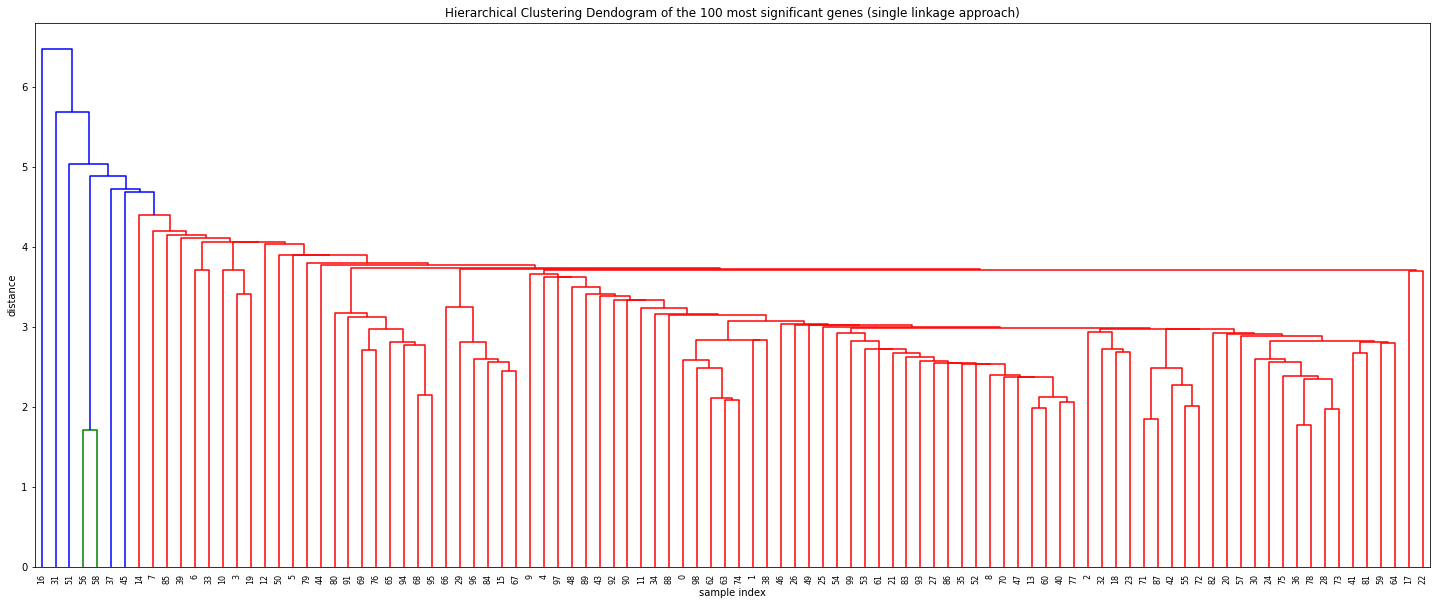

In [177]:
plot_dendogram(dendogram_single, "Hierarchical Clustering Dendogram of the 100 most significant genes (single linkage approach)")

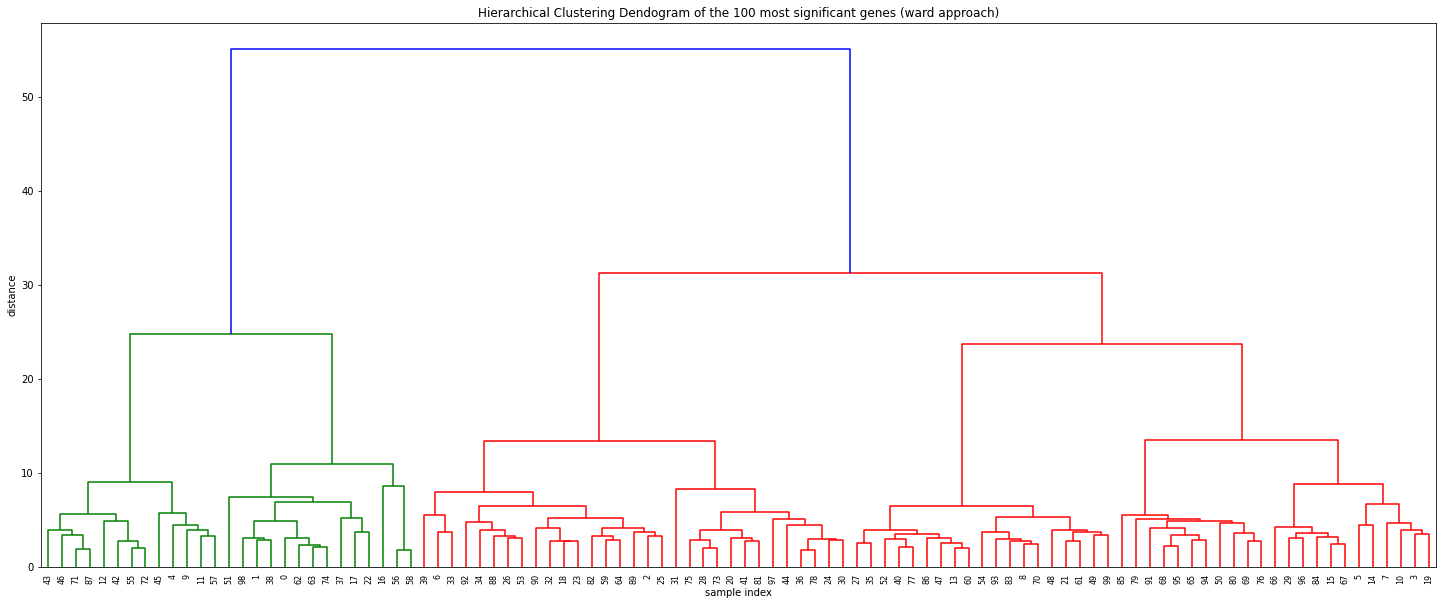

In [178]:
plot_dendogram(dendogram_ward, "Hierarchical Clustering Dendogram of the 100 most significant genes (ward approach)")

##### 1.2.b. Which method would you recommend based on the dendrograms for a clustering? Why?

The dendogram created using the **ward approach is better**, since the hierarchical tree is more equally distributed/merged. With the single linkage approach, a lot of clusters are successively growing by merging with a single gene.

##### 1.2.c. Familiarize yourself with **Cophenetic correlation coefficient** and calculate the cophenetic correlation distance for both single linkage as well as ward.

The Cophenetic correlation coefficien indicates how well the dendograms preserve the actual distances  of the data. The closer the coefficient is to one, the better the preservation.

In [179]:
c_single, coph_dists_single = cophenet(dendogram_single, pdist(most_signif_100_genes_db))
c_ward, coph_dists_ward = cophenet(dendogram_ward, pdist(most_signif_100_genes_db))
print(f"The Cophenetic correlation coefficient for the ward approach is           ~{round(c_ward,2)} \t({c_ward})")
print(f"The Cophenetic correlation coefficient for the single linkage approach is ~{round(c_single,2)} \t({c_single})")

The Cophenetic correlation coefficient for the ward approach is           ~0.71 	(0.7122409337749579)
The Cophenetic correlation coefficient for the single linkage approach is ~0.29 	(0.29202720217881184)


##### 1.2.d. Based on the cophenetic correlation distance, which clustering method performed better?

In [180]:
if c_ward < c_single:
    name = "single linkage"    
else:
    name = "ward"

print(f"The {name} approach is better, since its Cophenetic correlation coefficient (preservation of the original distances) is higher.")

The ward approach is better, since its Cophenetic correlation coefficient (preservation of the original distances) is higher.


#### 1.3. Apply two Agglomerative Clustering.

##### 1.3.a. One using single linkage and one using **ward method**.

In [181]:
### Singel linkage approach
agglomerative_single = AgglomerativeClustering(linkage='single').fit(most_signif_100_genes_db)
### Ward approach
agglomerative_ward = AgglomerativeClustering(linkage='ward').fit(most_signif_100_genes_db)

Visualizing this data is a bit tricky, since the feature vectors have 38 dimensions (number of samples). To still get an idea, that the agglomerative clustering was reasonable, we define a function that reduces the data to three dimensions and then display the agglomerative clustering as a heat map on this representation.

In [182]:
def pca_scatter_plt(dataframe, colours=None, name=None):
    X = dataframe.values
    # Project data down to 3D
    pca = PCA(n_components=3)
    X_three_d = pca.fit_transform(X)

    # Now plot in 3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    plt.title(f"Agglomerative Clustering")
    if name is not None:
        plt.title(f"Agglomerative Clustering using {name} method")

    x = X_three_d[:,0]
    y = X_three_d[:,1]
    z = X_three_d[:,2]
    
    img = ax.scatter(x, y, z)
    if colours is not None:
        img = ax.scatter(x, y, z, c=colours)
    plt.show()

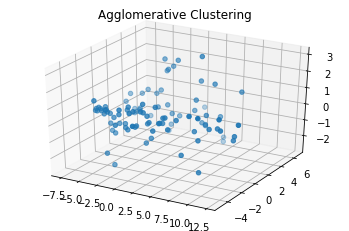

In [183]:
pca_scatter_plt(most_signif_100_genes_db)

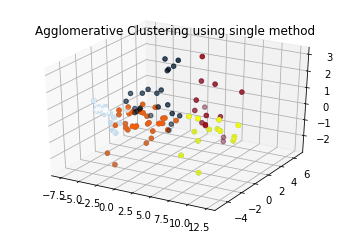

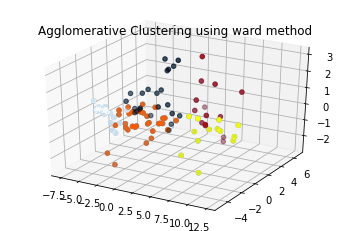

In [184]:
for linkage in ['single', 'ward']:
    agglo_clustering = AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=5).fit(most_signif_100_genes_db)
    
    pca_scatter_plt(most_signif_100_genes_db, agglo_clustering.labels_, linkage)

---
### Exercise 2 - PCA
Using the same leukemia dataset generate the feature matrix (transposed leukemia dataset) and the class labels (`golub.cl.csv`).

#### 2.1. Perform a PCA on the feature matrix and answer the following questions:

##### 2.1.a. How many PC’s do you need to explain at least 95% of the variance?

##### 2.1.b. Make a scatterplot of the projections on the first two PC‘s with the colouring corresponding to the class labels.

##### 2.1.c. Based on the scatterplot answer the following questions:

- Given the plot, do you think PCA might be a good choice? Why?

- Do you think n=2 components are a good choice? Why?

#### 2.2. Inform yourself regarding decorrelation of features in a dataset.

##### 2.2.a. Identify the correlated features in the dataset.

##### 2.2.b. Decorrelate the correlated datasets.

##### 2.2.c. What is the purpose of carrying out decorrelation of features in a dataset?

---
### Exercise 3 - Logistic Regression

#### 3.1. Using the reduced dataset from exercise 2.1, carry out the following tasks:

##### 3.1.a Generate a logistic regression model on the first 5 PCs of the reduced dataset using 80% of the total samples.

##### 3.1.b. Predict the labels for the remaining 20% of the samples and calculate your model’s accuracy

#### 3.2. Inform yourself about **Brier’s Score**. How can it be used to evaluate the performance of your model? Show by implementation.

#### 3.3. Assess the significance of your variables using the likelihood ratio test.